# Ungraded Lab: Data Augmentation on the Horses or Humans Dataset

In the previous lab, you saw how data augmentation helped improve the model's performance on unseen data. By tweaking the cat and dog training images, the model was able to learn features that are also representative of the validation data. However, applying data augmentation requires good understanding of your dataset. Simply transforming it randomly will not always yield good results.

In the next cells, you will apply the same techniques to the `Horses or Humans` dataset and analyze the results.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Download and Inspect the Dataset

You can uncomment the line of code below to download the dataset to your notebook.

In [ ]:
# Download the training set
#!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Download the validation set
#!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

You can run the following code to mount Google Drive in your Google Colab environment. This will allow you to access and work with files stored in your Google Drive directly from your Colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Access the path where the image dataset is located, and unzip it.

In [ ]:
import os
import zipfile # extract files .zip

# View current directory
print(f"The current path is: {os.getcwd()}")

# Path with cat and dog pictures
path_horses_humans_pic = '/content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W2/Ungraded/Lab2'
os.chdir(path_horses_humans_pic)
print(f"The new current path is: {path_horses_humans_pic}")

# Unzip the files only if the Files folder exists and is a directory in the file system
zip_files = 'Files.zip'  # Name of the zip folder
unzip_files = 'Files/'   # Name of the unzip folder

if os.path.exists(unzip_files) and os.path.isdir(unzip_files):
  print(f"The folder '{unzip_files}' already exists and is a directory.")
else:
  print(f"The folder '{unzip_files}' does not exist or is not a directory.")
  print(f"Unzip Files...")
  zip_ref = zipfile.ZipFile(zip_files, 'r')
  zip_ref.extractall(unzip_files)
  zip_ref.close()

# View files
!ls

The current path is: /content
The new current path is: /content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W2/Ungraded/Lab2
La carpeta 'Files/' no existe o no es un directorio.
Unzip Files...
C2_W2_Lab_2_horses_v_humans_augmentation.ipynb	Files  Files.zip


In [ ]:
# Base Directory
TRAIN_DIR = os.path.join(os.getcwd(), 'Files/Files', 'horse-or-human', 'train')
VAL_DIR = os.path.join(os.getcwd(), 'Files/Files', 'horse-or-human', 'validation')
print(f'There are {os.listdir(TRAIN_DIR)} images in train set and {os.listdir(VAL_DIR)} in validation set')

# Directory with training horse pictures
train_horse_dir = os.path.join(TRAIN_DIR, 'horses')

# Directory with training human pictures
train_human_dir = os.path.join(TRAIN_DIR, 'humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join(VAL_DIR, 'horses')

# Directory with validation human pictures
validation_human_dir = os.path.join(VAL_DIR, 'humans')

print(f'There are {len(os.listdir(train_horse_dir))} horses images {len(os.listdir(train_human_dir))} humans images in train set')
print(f'There are {len(os.listdir(validation_horse_dir))} horses images {len(os.listdir(validation_human_dir))} humans images in validation set')

There are ['horses', 'humans'] images in train set and ['horses', 'humans'] in validation set
There are 500 horses images 527 humans images in train set
There are 128 horses images 128 humans images in validation set


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import binary_crossentropy

class HorseHumanClassifier:
    def __init__(self):
        self.model = self.cnn_model()

    def cnn_model(self, cnn_filters=[16, 32, 64, 64, 64]):
        '''Builds a CNN for image binary classification'''
        cnn_model = Sequential([
            Input(shape=(300,300,3)), # Images de la forma (300,300,3)
            Rescaling(1./255.0), # This will rescale the image to [0,1]
        ])
        for f in cnn_filters: # Crear las capas convolucionales y maxpoolinglayer
            cnn_model.add(Conv2D(filters=f, kernel_size=(3, 3), activation='relu'))
            cnn_model.add(MaxPooling2D(2, 2))
        cnn_model.add(Flatten()) # Capa de aplanamiento
        cnn_model.add(Dense(units=512, activation='relu')) # 512 neuron hidden layer
        cnn_model.add(Dense(units=1, activation='sigmoid')) # Only 1 output neuron. It will contain a value from 0-1 where 0 for one class ('horses') and 1 for the other ('humans')
        return cnn_model

    def compile_model(self, optimizer=RMSprop, learning_rate=0.001, loss=binary_crossentropy, metrics=['accuracy']):
        self.model.compile(optimizer=optimizer(learning_rate=learning_rate), loss=loss, metrics=metrics)

    def summary(self):
        self.model.summary()

    def fit(self, train_dataset, epochs=15, validation_dataset=None, verbose=None):
        return self.model.fit(x=train_dataset, epochs=epochs, validation_data=validation_dataset, verbose=verbose)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)
LABEL_MODE = 'binary'
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

def create_dataset(directory, image_size, batch_size=None, label_mode=None, optimizer_dataset=False, shuffle=False):
  dataset =  image_dataset_from_directory(directory=directory, image_size=image_size, batch_size=batch_size, label_mode=label_mode)
  if optimizer_dataset:
    # Optimize the datasets for training
    dataset = dataset.cache() # Almacena en caché primero
    if shuffle:
      dataset.shuffle(SHUFFLE_BUFFER_SIZE) # Baraja si se especifica
    dataset.prefetch(PREFETCH_BUFFER_SIZE) # Realiza la operación de prefijado
  return dataset

# Optimize the datasets for training
train_dataset_final = create_dataset(TRAIN_DIR, IMAGE_SIZE, BATCH_SIZE, LABEL_MODE, True, True)
validation_dataset_final = create_dataset(VAL_DIR, IMAGE_SIZE, BATCH_SIZE, LABEL_MODE, True, False)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


## Data Augmentation

You will use the same layers as in the previous lab. This worked well for the Cats and Dogs dataset to avoid overfitting. See if it has the same effect here.

In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom

FILL_MODE = 'nearest'
random_flip_parameters = {"mode":'horizontal'}
random_rotation_parameters = {"factor":0.2, "fill_mode":FILL_MODE}
random_translation_parameters = {"height_factor":0.2, "width_factor":0.2, "fill_mode":FILL_MODE}
random_zoom_parameters = {"height_factor":0.2, "width_factor":None, "fill_mode":FILL_MODE}

def augmented_model(random_flip_pars={}, random_rotation_pars={}, random_translation_pars={}, random_zoom_pars={}):
        # Define fill mode.
        augmented_model = Sequential([
        # Specify the input shape.
        Input(shape=(300,300,3)),
        # Add the augmentation layers
        RandomFlip(mode=random_flip_pars["mode"]),
        RandomRotation(factor=random_rotation_pars["factor"], fill_mode=random_rotation_pars["fill_mode"]),
        RandomTranslation(height_factor=random_translation_pars["height_factor"], width_factor=random_translation_pars["width_factor"], fill_mode=random_translation_pars["fill_mode"]),
        RandomZoom(height_factor=random_zoom_pars["height_factor"], width_factor=random_zoom_pars["width_factor"], fill_mode=random_zoom_pars["fill_mode"]),
        ])
        return augmented_model

data_augmentation = augmented_model(random_flip_parameters, random_rotation_parameters, random_translation_parameters, random_zoom_parameters)

You will again use the `data_augmentation` model on some images to preview the transformations.

In [ ]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

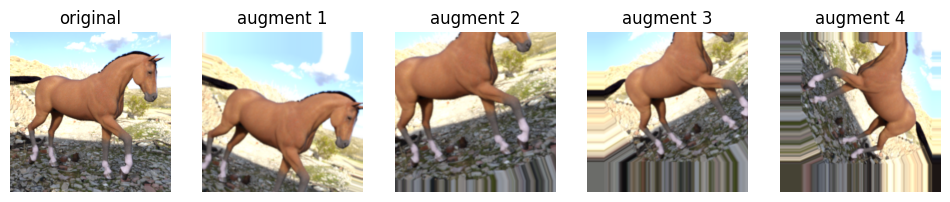

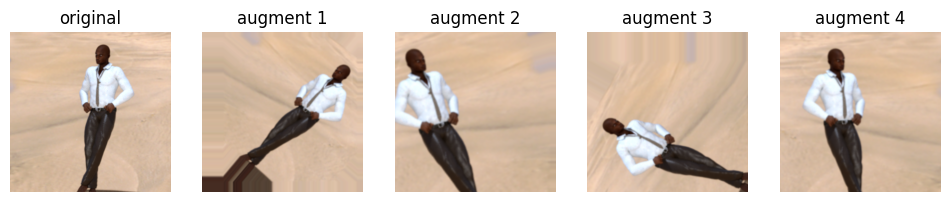

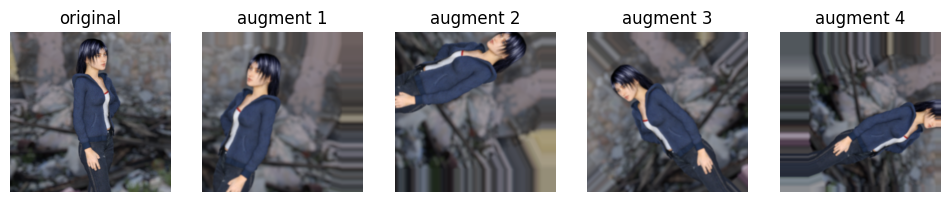

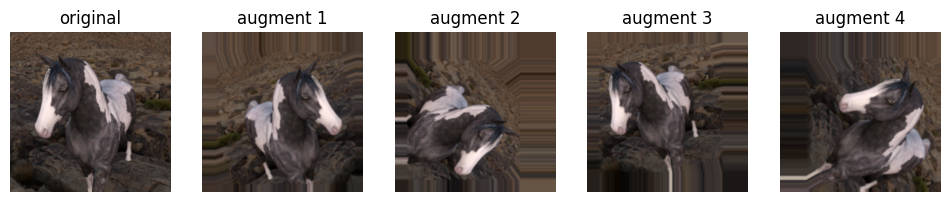

In [ ]:
import matplotlib.pyplot as plt

NUM_AUG = 4

# Get a batch of images
sample_batch = list(train_dataset_final.take(1))[0][0]

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# Delete the variable to free up some memory
del sample_batch

Now create a model attaching the `data_augmentation` model to the base model.

In [ ]:
# Instantiate the base model
model_without_aug = HorseHumanClassifier()

# Explorar el model sin aumentation y con aumentation
model_without_aug.summary()
data_augmentation.summary()

# Prepend the data augmentation layers to the base model
model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model_without_aug.model
])

# Compile the model
model_with_aug.compile(loss=binary_crossentropy,
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])

# Summary the model
model_with_aug.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 298, 298, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 147, 147, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 33, 33, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 300, 300, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 300, 300, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │       1,704,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

Now train the model for 20 epochs and observe what's happening with the training and validation accuracy. You will plot the results to see it more clearly.

In [ ]:
# Constant for epochs
EPOCHS = 20

# Train the model
history = model_with_aug.fit(
      train_dataset_final,
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_dataset_final)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.5391 - loss: 0.6873 - val_accuracy: 0.5000 - val_loss: 0.6854
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.6803 - loss: 0.6463 - val_accuracy: 0.5000 - val_loss: 0.6966
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.6965 - loss: 0.5896 - val_accuracy: 0.6016 - val_loss: 0.6500
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.7192 - loss: 0.5660 - val_accuracy: 0.8164 - val_loss: 0.6313
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.7242 - loss: 0.5648 - val_accuracy: 0.6172 - val_loss: 0.6255
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.7430 - loss: 0.5503 - val_accuracy: 0.7422 - val_loss: 0.5821
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.7271 - loss: 0.5585 - val_accuracy: 0.6289 - val_loss: 0.6150
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.7489 - loss: 0.5400 - val_accuracy: 0.6602 - v

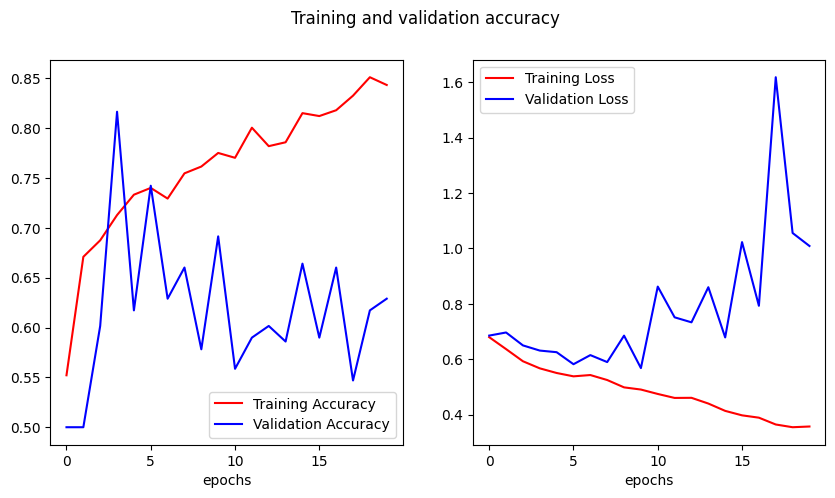

In [ ]:
import matplotlib.pyplot as plt

def plot_training_validation_accuracy_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Training and validation accuracy')

    for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
        ax[i].plot(epochs, data[0], 'r', label="Training " + label)
        ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
        ax[i].legend()
        ax[i].set_xlabel('epochs')

    plt.show()

plot_training_validation_accuracy_loss(history)

As you can see in the results, the preprocessing techniques used in augmenting the data did not help much in the results. The validation accuracy is fluctuating and not trending up like the training accuracy. This might be because the additional training data still do not represent the features in the validation data. For example, some human or horse poses in the validation set cannot be mimicked by the augmented data. It might also be that the background of the training images are also being learned by the model so the white background of the validation set is throwing the prediction off. (_Optional: you can learn about mismatched train/test distributions in [the later parts of this video](https://www.coursera.org/lecture/deep-neural-network/train-dev-test-sets-cxG1s)_).

Use the function below to compare the images on both datasets (note: you can also use the file explorer on the left to explore the images).

In [ ]:
import random

def show_images(dir_1, dir_2):
    '''plots 8 images each from two given directories'''

    # Output images in a 2x8 configuration
    nrows = 2
    ncols = 8

    # Get filenames from the two directories
    fnames_dir_1 = os.listdir(dir_1)
    fnames_dir_2 = os.listdir(dir_2)

    # Set up matplotlib fig, and size it to fit 2x8 images
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    # Get 8 random filenames and set the full paths
    next_pix_dir_1 = [os.path.join(dir_1, fname)
                      for fname in random.sample(fnames_dir_1, 8)]
    next_pix_dir_2 = [os.path.join(dir_2, fname)
                      for fname in random.sample(fnames_dir_2, 8)]

    # Plot the chosen images
    for i, img_path in enumerate(next_pix_dir_1 + next_pix_dir_2):

        # Set up subplot. subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)

        # Don't show axes or gridlines
        sp.axis('Off')

        # Load and show the image
        img = tf.keras.utils.load_img(img_path)
        plt.imshow(img)

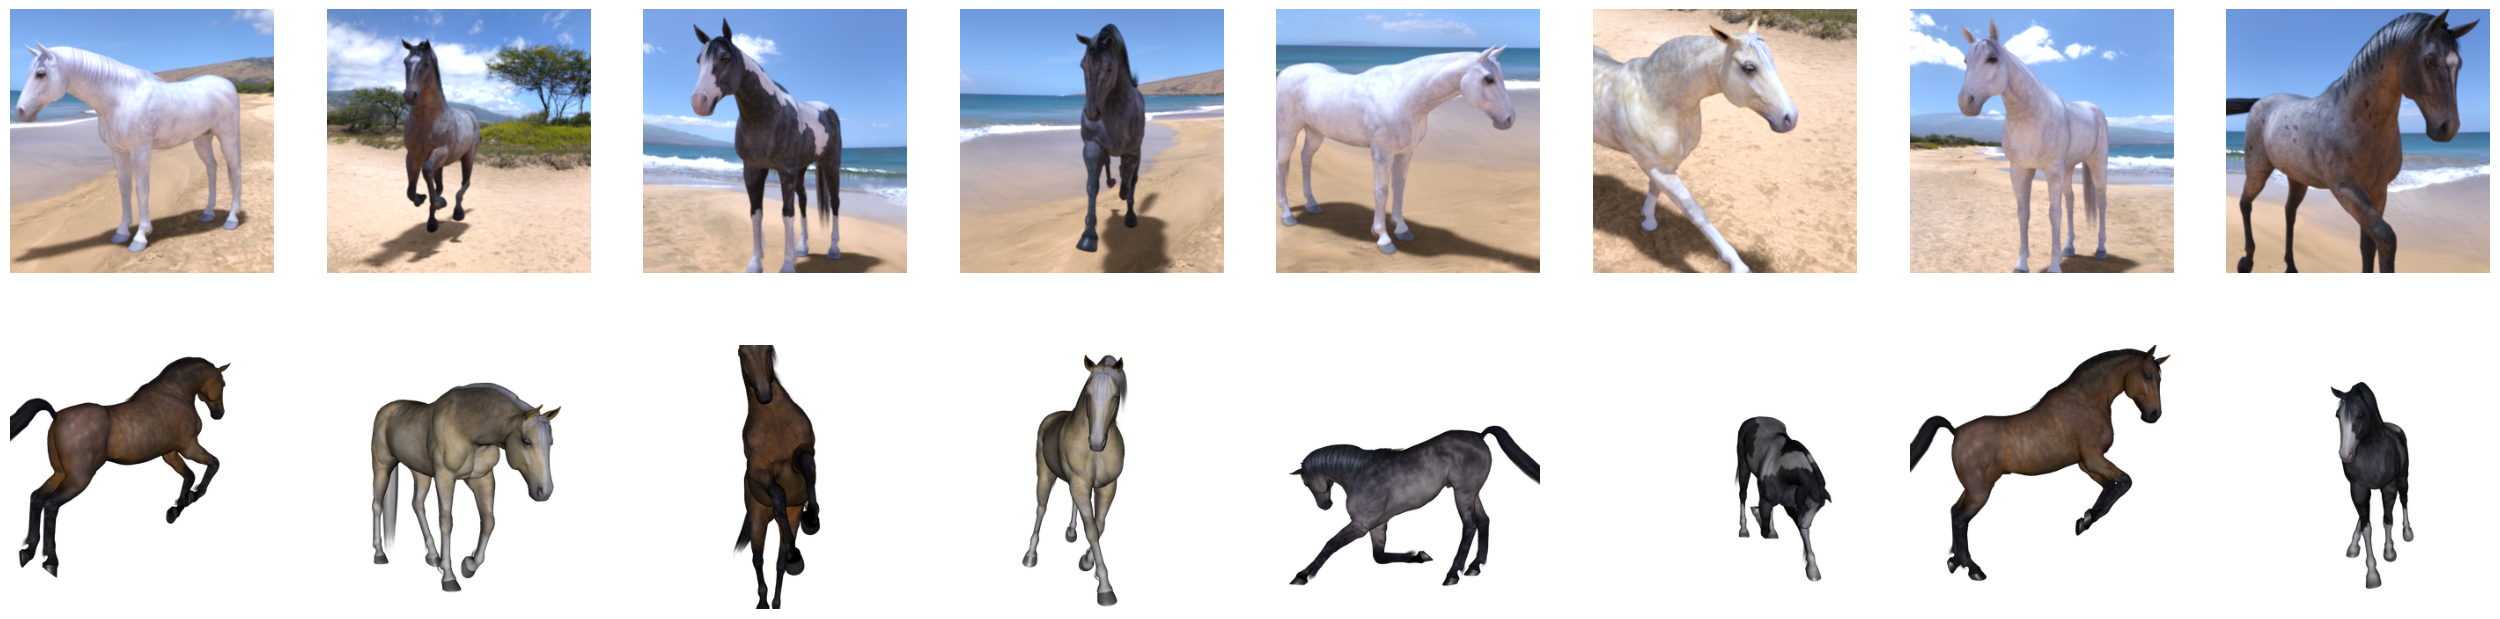

In [ ]:
# Show random train (first row) and validation (second row) horse images
show_images(train_horse_dir, validation_horse_dir)

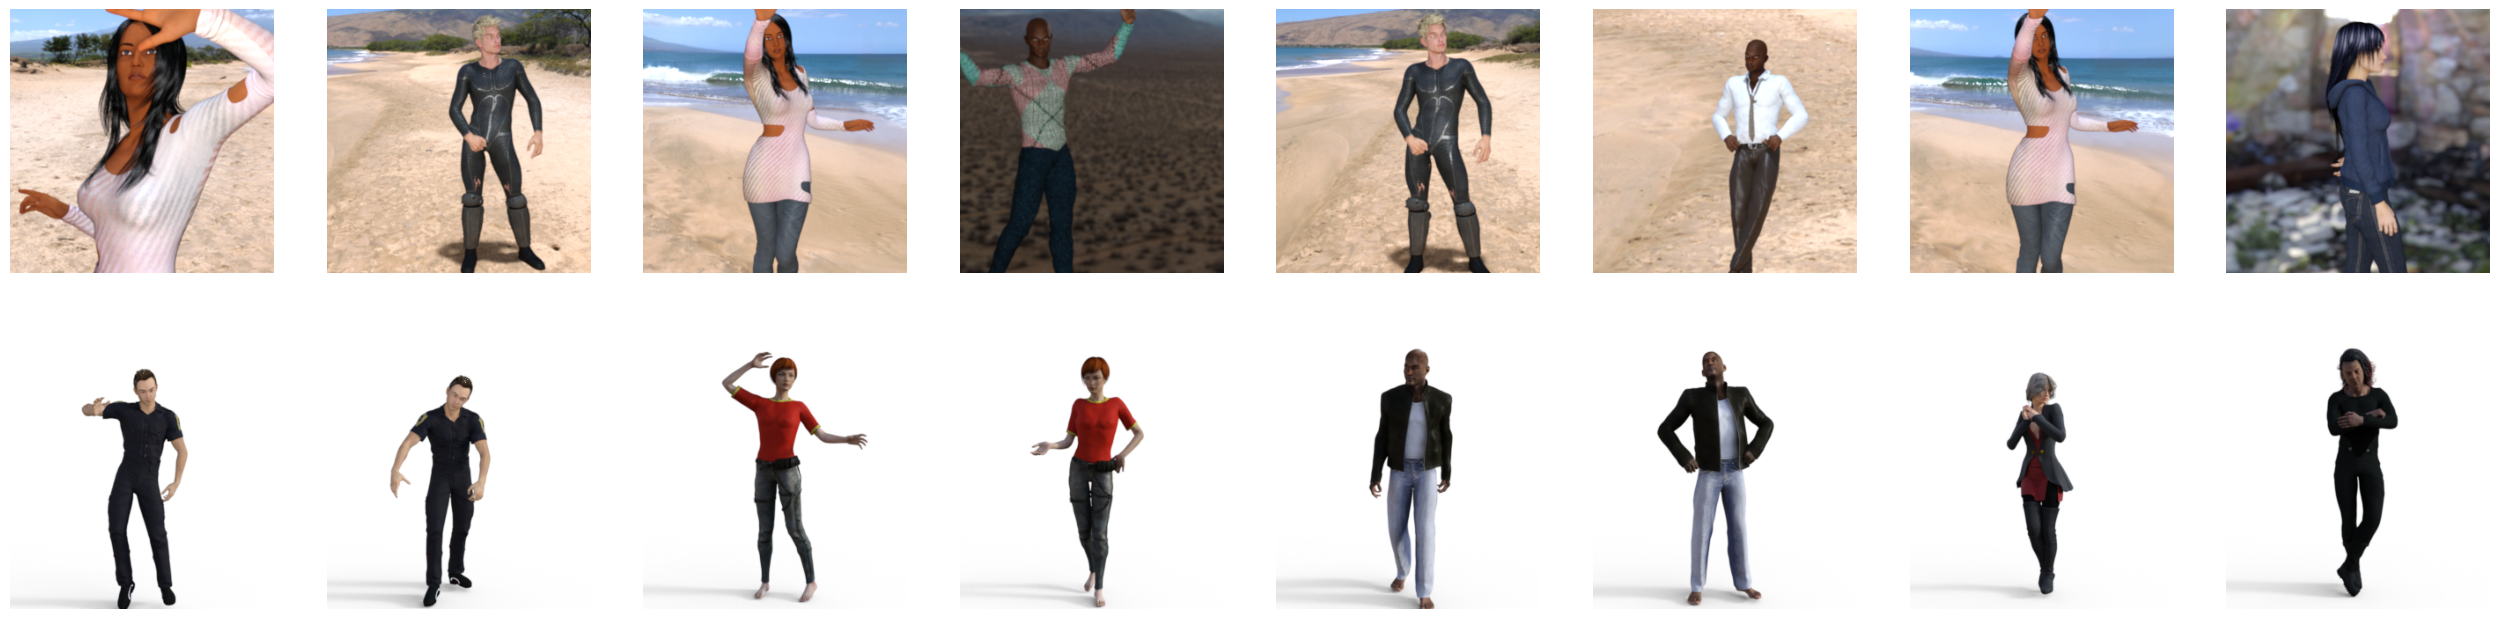

In [ ]:
# Show random train (first row) and validation (second row) human images
show_images(train_human_dir, validation_human_dir)

Based on these and the preview of the tranformed images earlier, see if it's possible to modify the data augmentation model to avoid overfitting. Getting satisfactory results can be difficult, and at this point, you can consider other techniques. You will see that in next week's lessons.

### Save the history

In [ ]:
import pickle
from google.colab import files

def download_history():
  with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Wrap Up

In [ ]:
# Shutdown the kernel to free up resources.
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)